# **Super-Resolution Generative Adversarial Network training**

Here in this jupyter notebook, we will train a super-resolution generative adversarial network (SRGAN), to create a high-resolution Antarctic bed Digital Elevation Model(DEM) from a low-resolution DEM.
In addition to that, we use additional correlated inputs that can also tell us something about the bed topography.

<img src="https://yuml.me/diagram/scruffy;dir:LR/class/[BEDMAP2 (1000m)]->[Generator model],[REMA (100m)]->[Generator model],[MEASURES Ice Flow Velocity (450m)]->[Generator model],[Generator model]->[High res bed DEM (250m)],[High res bed DEM (250m)]->[Discriminator model],[Groundtruth Image (250m)]->[Discriminator model],[Discriminator model]->[True/False]" alt="3 input SRGAN model"/>

# 0. Setup libraries

In [1]:
import os
import random
import sys
import typing

try:  # check if CUDA_VISIBLE_DEVICES environment variable is set
    os.environ["CUDA_VISIBLE_DEVICES"]
except KeyError:  # if not set, then set it to the first GPU
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import comet_ml
import IPython.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import quilt
import skimage.transform
import tqdm

import chainer
import chainer.functions as F
import chainer.links as L
import cupy
import livelossplot
import onnx_chainer
import optuna

from features.environment import _load_ipynb_modules

print("Python       :", sys.version.split("\n")[0])
chainer.print_runtime_info()

Python       : 3.6.6 | packaged by conda-forge | (default, Oct 11 2018, 14:33:06) 
Platform: Linux-4.15.0-43-generic-x86_64-with-debian-stretch-sid
Chainer: 6.0.0b1
NumPy: 1.14.5
CuPy:
  CuPy Version          : 6.0.0b1
  CUDA Root             : /usr/local/cuda
  CUDA Build Version    : 9020
  CUDA Driver Version   : 10000
  CUDA Runtime Version  : 9020
  cuDNN Build Version   : 7301
  cuDNN Version         : 7201
  NCCL Build Version    : 2307
iDeep: Not Available


In [2]:
# Set seed values
seed = 42
random.seed = seed
np.random.seed(seed=seed)
if cupy.is_available():
    for c in range(cupy.cuda.runtime.getDeviceCount()):
        with cupy.cuda.Device(c):
            cupy.random.seed(seed=42)

# 1. Load data
- Download pre-packaged data from [Quilt](https://github.com/quiltdata/quilt)
- Convert arrays for Chainer, from Numpy (CPU) to CuPy (GPU) format (if available)

In [3]:
def load_data_into_memory(
    redownload: bool = True,
    quilt_hash: str = "07346a5773aad87a71a57f83624289f5af507ad12f7008aec29eee209f98c399",
) -> (chainer.datasets.dict_dataset.DictDataset, str):
    """
    Downloads the prepackaged tiled data from quilt based on a hash,
    and loads it into CPU or GPU memory depending on what is available.
    """

    if redownload:
        quilt.install(
            package="weiji14/deepbedmap/model/train", hash=quilt_hash, force=True
        )
    pkg = quilt.load(pkginfo="weiji14/deepbedmap/model/train", hash=quilt_hash)

    W1_data = pkg.W1_data()  # miscellaneous data REMA
    W2_data = pkg.W2_data()  # miscellaneous data MEASURES Ice Flow
    X_data = pkg.X_data()  # low resolution BEDMAP2
    Y_data = pkg.Y_data()  # high resolution groundtruth
    # print(W1_data.shape, W2_data.shape, X_data.shape, Y_data.shape)

    # Detect if there is a CUDA GPU first
    if cupy.is_available():
        print("Using GPU")
        W1_data = chainer.backend.cuda.to_gpu(array=W1_data, device=None)
        W2_data = chainer.backend.cuda.to_gpu(array=W2_data, device=None)
        X_data = chainer.backend.cuda.to_gpu(array=X_data, device=None)
        Y_data = chainer.backend.cuda.to_gpu(array=Y_data, device=None)
    else:
        print("Using CPU only")

    return (
        chainer.datasets.DictDataset(X=X_data, W1=W1_data, W2=W2_data, Y=Y_data),
        quilt_hash,
    )

## 1.1 Split dataset into training (train) and development (dev) sets

In [4]:
def get_train_dev_iterators(
    dataset: chainer.datasets.dict_dataset.DictDataset,
    first_size: int,  # size of training set
    batch_size: int = 64,
    seed: int = 42,
) -> (
    chainer.iterators.serial_iterator.SerialIterator,
    int,
    chainer.iterators.serial_iterator.SerialIterator,
    int,
):
    """
    Create Chainer Dataset Iterators after splitting dataset into
    training and development (validation) sets.
    """

    # Train/Dev split of the dataset
    train_set, dev_set = chainer.datasets.split_dataset_random(
        dataset=dataset, first_size=first_size, seed=seed
    )

    # Create Chainer Dataset Iterators out of the split datasets
    train_iter = chainer.iterators.SerialIterator(
        dataset=train_set, batch_size=batch_size, repeat=True, shuffle=True
    )
    dev_iter = chainer.iterators.SerialIterator(
        dataset=dev_set, batch_size=batch_size, repeat=True, shuffle=False
    )

    print(
        f"Training dataset: {len(train_set)} tiles,",
        f"Development dataset: {len(dev_set)} tiles",
    )

    return train_iter, len(train_set), dev_iter, len(dev_set)

# 2. Architect model

Enhanced Super Resolution Generative Adversarial Network (ESRGAN) model based on [Wang et al. 2018](https://arxiv.org/abs/1809.00219v2).
Refer to original Pytorch implementation at https://github.com/xinntao/ESRGAN.
See also previous (non-enhanced) SRGAN model architecture by [Ledig et al. 2017](https://arxiv.org/abs/1609.04802).

## 2.1 Generator Network Architecture

![ESRGAN architecture - Generator Network composed of many Dense Convolutional Blocks](https://github.com/xinntao/ESRGAN/raw/master/figures/architecture.jpg)

3 main components: 1) Input Block, 2) Residual Blocks, 3) Upsampling Blocks

### 2.1.1 Input block, specially customized for DeepBedMap to take in 3 different inputs

Details of the first convolutional layer for each input:

- Input tiles are 8000m by 8000m.
- Convolution filter kernels are 3000m by 3000m.
- Strides are 1000m by 1000m.

Example: for a 100m spatial resolution tile:

- Input tile is 80pixels by 80pixels
- Convolution filter kernels are 30pixels by 30pixels
- Strides are 10pixels by 10pixels

Note that these first convolutional layers uses '**valid**' padding, see https://keras.io/layers/convolutional/ for more information.

In [5]:
class DeepbedmapInputBlock(chainer.Chain):
    """
    Custom input block for DeepBedMap.

    Each filter kernel is 3km by 3km in size, with a 1km stride and no padding.
    So for a 1km resolution image, (i.e. 1km pixel size):
    kernel size is (3, 3), stride is (1, 1), and pad is (0, 0)

      (?,1,10,10) --Conv2D-- (?,32,8,8) \
    (?,1,100,100) --Conv2D-- (?,32,8,8) --Concat-- (?,96,8,8)
      (?,1,20,20) --Conv2D-- (?,32,8,8) /

    """

    def __init__(self, out_channels=32):
        super().__init__()
        init_weights = chainer.initializers.HeNormal(scale=0.1, fan_option="fan_in")

        with self.init_scope():
            self.conv_on_X = L.Convolution2D(
                in_channels=1,
                out_channels=out_channels,
                ksize=(3, 3),
                stride=(1, 1),
                pad=(0, 0),  # 'valid' padding
                initialW=init_weights,
            )
            self.conv_on_W1 = L.Convolution2D(
                in_channels=1,
                out_channels=out_channels,
                ksize=(30, 30),
                stride=(10, 10),
                pad=(0, 0),  # 'valid' padding
                initialW=init_weights,
            )
            self.conv_on_W2 = L.Convolution2D(
                in_channels=1,
                out_channels=out_channels,
                ksize=(6, 6),
                stride=(2, 2),
                pad=(0, 0),  # 'valid' padding
                initialW=init_weights,
            )

    def forward(self, x, w1, w2):
        """
        Forward computation, i.e. evaluate based on inputs X, W1 and W2
        """
        x_ = self.conv_on_X(x)
        w1_ = self.conv_on_W1(w1)
        w2_ = self.conv_on_W2(w2)

        a = F.concat(xs=(x_, w1_, w2_))
        return a

### 2.1.2 Residual Block

![The Residual in Residual Dense Block in detail](https://raw.githubusercontent.com/xinntao/ESRGAN/master/figures/RRDB.png)

In [6]:
class ResidualDenseBlock(chainer.Chain):
    """
    Residual Dense Block made up of 5 Convolutional2D-LeakyReLU layers.
    Final output has a residual scaling factor.
    """

    def __init__(
        self,
        in_out_channels: int = 64,
        inter_channels: int = 32,
        residual_scaling: float = 0.3,
    ):
        super().__init__()
        self.residual_scaling = residual_scaling
        init_weights = chainer.initializers.HeNormal(scale=0.1, fan_option="fan_in")

        with self.init_scope():
            self.conv_layer1 = L.Convolution2D(
                in_channels=in_out_channels,
                out_channels=inter_channels,
                ksize=(3, 3),
                stride=(1, 1),
                pad=1,  # 'same' padding
                initialW=init_weights,
            )
            self.conv_layer2 = L.Convolution2D(
                in_channels=None,
                out_channels=inter_channels,
                ksize=(3, 3),
                stride=(1, 1),
                pad=1,  # 'same' padding
                initialW=init_weights,
            )
            self.conv_layer3 = L.Convolution2D(
                in_channels=None,
                out_channels=inter_channels,
                ksize=(3, 3),
                stride=(1, 1),
                pad=1,  # 'same' padding
                initialW=init_weights,
            )
            self.conv_layer4 = L.Convolution2D(
                in_channels=None,
                out_channels=inter_channels,
                ksize=(3, 3),
                stride=(1, 1),
                pad=1,  # 'same' padding
                initialW=init_weights,
            )
            self.conv_layer5 = L.Convolution2D(
                in_channels=None,
                out_channels=in_out_channels,
                ksize=(3, 3),
                stride=(1, 1),
                pad=1,  # 'same' padding
                initialW=init_weights,
            )

    def forward(self, x):
        """
        Forward computation, i.e. evaluate based on input x
        """

        a0 = x

        a1 = self.conv_layer1(a0)
        a1 = F.leaky_relu(x=a1, slope=0.2)
        a1_cat = F.concat(xs=(a0, a1), axis=1)

        a2 = self.conv_layer2(a1_cat)
        a2 = F.leaky_relu(x=a2, slope=0.2)
        a2_cat = F.concat(xs=(a0, a1, a2), axis=1)

        a3 = self.conv_layer3(a2_cat)
        a3 = F.leaky_relu(x=a3, slope=0.2)
        a3_cat = F.concat(xs=(a0, a1, a2, a3), axis=1)

        a4 = self.conv_layer4(a3_cat)
        a4 = F.leaky_relu(x=a4, slope=0.2)
        a4_cat = F.concat(xs=(a0, a1, a2, a3, a4), axis=1)

        a5 = self.conv_layer5(a4_cat)

        # Final concatenation, with residual scaling of 0.2
        a6 = F.add(a5 * self.residual_scaling, a0)

        return a6

In [7]:
class ResInResDenseBlock(chainer.Chain):
    """
    Residual in Residual Dense block made of 3 Residual Dense Blocks

       ------------  ----------  ------------
      |            ||          ||            |
    -----DenseBlock--DenseBlock--DenseBlock-(+)--
      |                                      |
       --------------------------------------

    """

    def __init__(
        self,
        denseblock_class=ResidualDenseBlock,
        out_channels: int = 64,
        residual_scaling: float = 0.3,
    ):
        super().__init__()
        self.residual_scaling = residual_scaling

        with self.init_scope():
            self.residual_dense_block1 = denseblock_class(
                residual_scaling=residual_scaling
            )
            self.residual_dense_block2 = denseblock_class(
                residual_scaling=residual_scaling
            )
            self.residual_dense_block3 = denseblock_class(
                residual_scaling=residual_scaling
            )

    def forward(self, x):
        """
        Forward computation, i.e. evaluate based on input x
        """
        a1 = self.residual_dense_block1(x)
        a2 = self.residual_dense_block2(a1)
        a3 = self.residual_dense_block3(a2)

        # Final concatenation, with residual scaling of 0.2
        a4 = F.add(a3 * self.residual_scaling, x)

        return a4

### 2.1.3 Build the Generator Network, with upsampling layers!

![3 inputs feeding into the Generator Network, producing a high resolution prediction output](https://yuml.me/dffffcb0.png)

<!--[W2_input(MEASURES)|20x20x1]-k6n32s2>[W2_inter|8x8x32],[W2_inter]->[Concat|8x8x96]
[X_input(BEDMAP2)|10x10x1]-k3n32s1>[X_inter|8x8x32],[X_inter]->[Concat|8x8x96]
[W1_input(REMA)|100x100x1]-k30n32s10>[W1_inter|8x8x32],[W1_inter]->[Concat|8x8x96]
[Concat|8x8x96]->[Generator-Network|Many-Residual-Blocks],[Generator-Network]->[Y_hat(High-Resolution_DEM)|32x32x1]-->

In [8]:
class GeneratorModel(chainer.Chain):
    """
    The generator network which is a deconvolutional neural network.
    Converts a low resolution input into a super resolution output.

    Glues the input block with several residual blocks and upsampling layers

    Parameters:
      input_shape -- shape of input tensor in tuple format (height, width, channels)
      num_residual_blocks -- how many Conv-LeakyReLU-Conv blocks to use
      scaling -- even numbered integer to increase resolution (e.g. 0, 2, 4, 6, 8)
      out_channels -- integer representing number of output channels/filters/kernels

    Example:
      An input_shape of (8,8,1) passing through 16 residual blocks with a scaling of 4
      and output_channels 1 will result in an image of shape (32,32,1)

    >>> generator_model = GeneratorModel()
    >>> y_pred = generator_model.forward(
    ...     inputs={
    ...         "x": np.random.rand(1, 1, 10, 10).astype("float32"),
    ...         "w1": np.random.rand(1, 1, 100, 100).astype("float32"),
    ...         "w2": np.random.rand(1, 1, 20, 20).astype("float32"),
    ...     }
    ... )
    >>> y_pred.shape
    (1, 1, 32, 32)
    >>> generator_model.count_params()
    7649793
    """

    def __init__(
        self,
        inblock_class=DeepbedmapInputBlock,
        resblock_class=ResInResDenseBlock,
        num_residual_blocks: int = 10,
        residual_scaling: float = 0.3,
        out_channels: int = 1,
    ):
        super().__init__()
        self.num_residual_blocks = num_residual_blocks
        self.residual_scaling = residual_scaling
        init_weights = chainer.initializers.HeNormal(scale=0.1, fan_option="fan_in")

        with self.init_scope():

            # Initial Input and Residual Blocks
            self.input_block = inblock_class()
            self.pre_residual_conv_layer = L.Convolution2D(
                in_channels=None,
                out_channels=64,
                ksize=(3, 3),
                stride=(1, 1),
                pad=1,  # 'same' padding
                initialW=init_weights,
            )
            self.residual_network = resblock_class(
                residual_scaling=residual_scaling
            ).repeat(n_repeat=num_residual_blocks)
            self.post_residual_conv_layer = L.Convolution2D(
                in_channels=None,
                out_channels=64,
                ksize=(3, 3),
                stride=(1, 1),
                pad=1,  # 'same' padding
                initialW=init_weights,
            )

            # Upsampling Layers
            self.pre_upsample_conv_layer_1 = L.Convolution2D(
                in_channels=None,
                out_channels=256,
                ksize=(3, 3),
                stride=(1, 1),
                pad=1,  # 'same' padding
                initialW=init_weights,
            )
            self.pre_upsample_conv_layer_2 = L.Convolution2D(
                in_channels=None,
                out_channels=256,
                ksize=(3, 3),
                stride=(1, 1),
                pad=1,  # 'same' padding
                initialW=init_weights,
            )

            # Final post-upsamle layers
            self.final_conv_layer1 = L.Convolution2D(
                in_channels=None,
                out_channels=64,
                ksize=(3, 3),
                stride=(1, 1),
                pad=1,  # 'same' padding
                initialW=init_weights,
            )
            self.final_conv_layer2 = L.Convolution2D(
                in_channels=None,
                out_channels=out_channels,
                ksize=(3, 3),
                stride=(1, 1),
                pad=1,  # 'same' padding
                initialW=init_weights,
            )

    def forward(self, inputs: dict):
        """
        Forward computation, i.e. evaluate based on inputs

        Input dictionary needs to have keys "x", "w1", "w2"
        """
        # 0 part
        # Resize inputs o right scale using convolution (hardcoded kernel_size and strides)
        # Also concatenate all inputs
        a0 = self.input_block(x=inputs["x"], w1=inputs["w1"], w2=inputs["w2"])

        # 1st part
        # Pre-residual k3n64s1
        a1 = self.pre_residual_conv_layer(a0)
        a1 = F.leaky_relu(x=a1, slope=0.2)

        # 2nd part
        # Residual blocks k3n64s1
        a2 = self.residual_network(a1)

        # 3rd part
        # Post-residual blocks k3n64s1
        a3 = self.post_residual_conv_layer(a2)
        a3 = F.add(a1, a3)

        # 4th part
        # Upsampling (if 4; run twice, if 8; run thrice, etc.) k3n256s1
        a4_1 = self.pre_upsample_conv_layer_1(a3)
        a4_1 = F.depth2space(X=a4_1, r=2)
        a4_1 = F.leaky_relu(x=a4_1, slope=0.2)
        a4_2 = self.pre_upsample_conv_layer_2(a4_1)
        a4_2 = F.depth2space(X=a4_2, r=2)
        a4_2 = F.leaky_relu(x=a4_2, slope=0.2)

        # 5th part
        # Generate high resolution output k3n64s1 and k3n1s1
        a5_1 = self.final_conv_layer1(a4_2)
        a5_1 = F.leaky_relu(x=a5_1, slope=0.2)
        a5_2 = self.final_conv_layer2(a5_1)

        return a5_2

## 2.2 Discriminator Network Architecture

Discriminator component is based on Deep Convolutional Generative Adversarial Networks by [Radford et al., 2015](https://arxiv.org/abs/1511.06434).

Note that figure below shows the 2017 (non-enhanced) SRGAN discriminator neural network architecture.
The 2018 ESRGAN version is basically the same architecture, as only the loss function was changed.
Note that the BatchNormalization layers **are still preserved** within the Convolutional blocks (see relevant line in original Pytorch implementation [here](https://github.com/xinntao/BasicSR/blob/902b4ae1f4beec7359de6e62ed0aebfc335d8dfd/codes/models/modules/architecture.py#L88)).

![SRGAN architecture - Discriminator Network](https://arxiv-sanity-sanity-production.s3.amazonaws.com/render-output/399644/images/used/jpg/discriminator.jpg)

![Discriminator Network](https://yuml.me/diagram/scruffy/class/[High-Resolution_DEM|32x32x1]->[Discriminator-Network],[Discriminator-Network]->[False/True|0/1])

In [9]:
class DiscriminatorModel(chainer.Chain):
    """
    The discriminator network which is a convolutional neural network.
    Takes ONE high resolution input image and predicts whether it is
    real or fake on a scale of 0 to 1, where 0 is fake and 1 is real.

    Consists of several Conv2D-BatchNorm-LeakyReLU blocks, followed by
    a fully connected linear layer with LeakyReLU activation and a final
    fully connected linear layer with Sigmoid activation.

    >>> discriminator_model = DiscriminatorModel()
    >>> y_pred = discriminator_model.forward(
    ...     inputs={
    ...         "x": np.random.rand(2, 1, 32, 32).astype("float32"),
    ...     }
    ... )
    >>> y_pred.shape
    (2, 1)
    >>> discriminator_model.count_params()
    6824193
    """

    def __init__(self):
        super().__init__()
        init_weights = chainer.initializers.GlorotUniform(scale=1.0)

        with self.init_scope():

            self.conv_layer0 = L.Convolution2D(
                in_channels=None,
                out_channels=64,
                ksize=(3, 3),
                stride=(1, 1),
                pad=1,  # 'same' padding
                nobias=False,  # default, have bias
                initialW=init_weights,
            )
            self.conv_layer1 = L.Convolution2D(None, 64, 3, 1, 1, False, init_weights)
            self.conv_layer2 = L.Convolution2D(None, 64, 3, 2, 1, False, init_weights)
            self.conv_layer3 = L.Convolution2D(None, 128, 3, 1, 1, False, init_weights)
            self.conv_layer4 = L.Convolution2D(None, 128, 3, 2, 1, False, init_weights)
            self.conv_layer5 = L.Convolution2D(None, 256, 3, 1, 1, False, init_weights)
            self.conv_layer6 = L.Convolution2D(None, 256, 3, 2, 1, False, init_weights)
            self.conv_layer7 = L.Convolution2D(None, 512, 3, 1, 1, False, init_weights)
            self.conv_layer8 = L.Convolution2D(None, 512, 3, 2, 1, False, init_weights)

            self.batch_norm1 = L.BatchNormalization(axis=(0, 2, 3), eps=0.001)
            self.batch_norm2 = L.BatchNormalization(axis=(0, 2, 3), eps=0.001)
            self.batch_norm3 = L.BatchNormalization(axis=(0, 2, 3), eps=0.001)
            self.batch_norm4 = L.BatchNormalization(axis=(0, 2, 3), eps=0.001)
            self.batch_norm5 = L.BatchNormalization(axis=(0, 2, 3), eps=0.001)
            self.batch_norm6 = L.BatchNormalization(axis=(0, 2, 3), eps=0.001)
            self.batch_norm7 = L.BatchNormalization(axis=(0, 2, 3), eps=0.001)
            self.batch_norm8 = L.BatchNormalization(axis=(0, 2, 3), eps=0.001)

            self.linear_1 = L.Linear(in_size=None, out_size=1024, initialW=init_weights)
            self.linear_2 = L.Linear(in_size=None, out_size=1, initialW=init_weights)

    def forward(self, inputs: dict):
        """
        Forward computation, i.e. evaluate based on inputs

        Input dictionary needs to have keys "x"
        """

        # 1st part
        # Convolutonal Block without Batch Normalization k3n64s1
        a0 = self.conv_layer0(x=inputs["x"])
        a0 = F.leaky_relu(x=a0, slope=0.2)

        # 2nd part
        # Convolutional Blocks with Batch Normalization k3n{64*f}s{1or2}
        a1 = self.conv_layer1(x=a0)
        a1 = self.batch_norm1(x=a1)
        a1 = F.leaky_relu(x=a1, slope=0.2)
        a2 = self.conv_layer2(x=a1)
        a2 = self.batch_norm2(x=a2)
        a2 = F.leaky_relu(x=a2, slope=0.2)
        a3 = self.conv_layer3(x=a2)
        a3 = self.batch_norm3(x=a3)
        a3 = F.leaky_relu(x=a3, slope=0.2)
        a4 = self.conv_layer4(x=a3)
        a4 = self.batch_norm4(x=a4)
        a4 = F.leaky_relu(x=a4, slope=0.2)
        a5 = self.conv_layer5(x=a4)
        a5 = self.batch_norm5(x=a5)
        a5 = F.leaky_relu(x=a5, slope=0.2)
        a6 = self.conv_layer6(x=a5)
        a6 = self.batch_norm6(x=a6)
        a6 = F.leaky_relu(x=a6, slope=0.2)
        a7 = self.conv_layer7(x=a6)
        a7 = self.batch_norm7(x=a7)
        a7 = F.leaky_relu(x=a7, slope=0.2)
        a8 = self.conv_layer8(x=a7)
        a8 = self.batch_norm8(x=a8)
        a8 = F.leaky_relu(x=a8, slope=0.2)

        # 3rd part
        # Flatten, Dense (Fully Connected) Layers and Output
        a9 = F.reshape(x=a8, shape=(len(a8), -1))  # flatten while keeping batch_size
        a9 = self.linear_1(x=a9)
        a9 = F.leaky_relu(x=a9, slope=0.2)
        a10 = self.linear_2(x=a9)
        # a10 = F.sigmoid(x=a10)  # no sigmoid activation, as it is in the loss function

        return a10

## 2.3 Define Loss function and Metrics for the Generator and Discriminator Networks

Now we define the Perceptual Loss function for our Generator and Discriminator neural network models, where:

$$Perceptual Loss = Content Loss + Adversarial Loss$$

![Perceptual Loss in an Enhanced Super Resolution Generative Adversarial Network](https://yuml.me/db58d683.png)

<!--
[LowRes-Inputs]-Generator>[SuperResolution_DEM]
[SuperResolution_DEM]-.->[note:Content-Loss|MeanAbsoluteError{bg:yellow}]
[HighRes-Groundtruth_DEM]-.->[note:Content-Loss]
[SuperResolution_DEM]-Discriminator>[False_or_True_Prediction]
[HighRes-Groundtruth_DEM]-Discriminator>[False_or_True_Prediction]
[False_or_True_Prediction]<->[False_or_True_Label]
[False_or_True_Prediction]-.->[note:Adversarial-Loss|BinaryCrossEntropy{bg:yellow}]
[False_or_True_Label]-.->[note:Adversarial-Loss]
[note:Content-Loss]-.->[note:Perceptual-Loss{bg:gold}]
[note:Adversarial-Loss]-.->[note:Perceptual-Loss{bg:gold}]
-->

### Content Loss

The original SRGAN paper by [Ledig et al. 2017](https://arxiv.org/abs/1609.04802v5) calculates *Content Loss* based on the ReLU activation layers of the pre-trained 19 layer VGG network.
The implementation below is less advanced, simply using an L1 loss, i.e., a pixel-wise [Mean Absolute Error (MAE) loss](https://keras.io/losses/#mean_absolute_error) as the *Content Loss*.
Specifically, the *Content Loss* is calculated as the MAE difference between the output of the generator model (i.e. the predicted Super Resolution Image) and that of the groundtruth image (i.e. the true High Resolution Image).

$$ e_i = ||G(x_{i}) - y_i||_{1} $$

$$ Loss_{Content} = Mean Absolute Error = \dfrac{1}{n} \sum\limits_{i=1}^n e_i $$

where $G(x_{i})$ is the Generator Network's predicted value, and $y_i$ is the groundtruth value, respectively at pixel $i$.
$e_i$ thus represents the absolute error (L1 loss) (denoted by $||\dots||_{1}$) between the predicted and groundtruth value.
We then sum all the pixel-wise errors $e_i,\dots,e_n$ and divide by the number of pixels $n$ to get the Arithmetic Mean $\dfrac{1}{n} \sum\limits_{i=1}^n$ of our error which is our *Content Loss*.

### Adversarial Loss

The *Adversarial Loss* or *Generative Loss* (confusing I know) is the same as in the original SRGAN paper.
It is defined based on the probabilities of the discriminator believing that the reconstructed Super Resolution Image is a natural High Resolution Image.
The implementation below uses the [Binary CrossEntropy loss](https://keras.io/losses/#binary_crossentropy).
Specifically, this *Adversarial Loss* is calculated between the output of the discriminator model (a value between 0 and 1) and that of the groundtruth label (a boolean value of either 0 or 1).

$$ Loss_{Adversarial} = Binary Cross Entropy Loss = -\dfrac{1}{n} \sum\limits_{i=1}^n ( y_i ln(\sigma(x_i)) + (1-y_i) ln(1 - \sigma(x_i) ) $$

where $\sigma$ is the [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) activation function, $\sigma = \dfrac{1}{1+e^{-x}} = \dfrac{e^x}{e^x+1}$, $y_i$ is the groundtruth label (1 for real, 0 for fake) and $x_i$ is the prediction (before sigmoid activation is applied), all respectively at pixel $i$.

$\sigma(x)$ is basically the sigmoid activated output from a Standard Discriminator neural network, which some people also denote as $D(.)$.
Technically, some people also write $D(x) = \sigma(C(x))$, where $C(x)$ is the raw, non-transformed output from the Discriminator neural network (i.e. no sigmoid activation applied) on the input data $x$.
For simplicity, we now denote $C(x)$ simply as $x$ in the following equations, i.e. using $\sigma(x)$ to replace $\sigma(C(x))$.

Again, the [Binary Cross Entropy Loss](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_error_function_and_logistic_regression) calculated on one pixel is defined as follows:

$$ -( y ln(\sigma(x)) + (1-y) ln(1 - \sigma(x) )$$

With the full expansion as such:

$$ -\bigg[ y ln\big(\dfrac{e^x}{e^x+1}\big) + (1-y) ln\big(1 - \dfrac{e^x}{e^x+1}\big) \bigg] $$

The above equation is mathematically equivalent to the one below, and can be derived using [Logarithm rules](https://en.wikipedia.org/wiki/Logarithm#Product,_quotient,_power,_and_root) such as the Power Rule and Product Rule, and using the fact that $ln(e)=1$ and $ln(1)=0$:

$$ -[ xy - ln(1+e^x) ] $$

However, this reformed equation is numerically unstable (see discussion [here](https://www.reddit.com/r/MachineLearning/comments/4euzmk/logsumexp_for_logistic_regression/)), and is good for values of $x<0$.
For values of $x>=0$, there is an alternative representation which we can derive:

$$ -[ xy - ln(1+e^x) - x + x ] $$
$$ -[ x(y-1) - ln(1 + e^x) + ln(e^x) ] $$
$$ -\bigg[ x(y-1) - ln\big(\dfrac{e^x}{1+e^x}\big) \bigg] $$
$$ -\bigg[ x(y-1) - ln\big(\dfrac{1}{1+e^{-x}}\big) \bigg] $$
$$ - [ x(y-1) - ln(1) + ln(1+e^{-x}) ] $$
$$ - [ x(y-1) + ln(1+e^{-x}) $$

In order to have a numerically stable function that works for both $x<0$ and $x>=0$, we can write it like so as in Caffe's implementation:

$$ -[ x(y - 1_{x>=0} - ln(1+e^{x-2x\cdot1_{x>=0}}) ] $$

Alternatively, Chainer does it like so:

$$ -[ x(y - 1_{x>=0} - ln(1+e^{-|x|}) ] $$

Or in Python code (the Chainer implemention from [here](https://github.com/chainer/chainer/blob/v6.0.0b1/chainer/functions/loss/sigmoid_cross_entropy.py#L41-L44)), bearing in mind that the natural logarithm $ln$ is `np.log` in Numpy:

```python
    sigmoidbinarycrossentropyloss = -(x * (y - (x >= 0)) - np.log1p(np.exp(-np.abs(x))))
```

See also how [Pytorch](https://pytorch.org/docs/stable/nn.html?highlight=bcewithlogitsloss#torch.nn.BCEWithLogitsLoss) and [Tensorflow](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) implements this in a numerically stable manner.

In [10]:
def calculate_generator_loss(
    y_pred: chainer.variable.Variable,
    y_true: cupy.ndarray,
    fake_labels: cupy.ndarray,
    real_labels: cupy.ndarray,
    fake_minus_real_target: cupy.ndarray,
    real_minus_fake_target: cupy.ndarray,
    content_loss_weighting: float = 5e-3,
    adversarial_loss_weighting: float = 1e-2,
) -> chainer.variable.Variable:
    """
    This function calculates the weighted sum between
    "Content Loss" and "Adversarial Loss".
    which forms the basis for training the Generator Network.

    >>> calculate_generator_loss(
    ...     y_pred=chainer.variable.Variable(data=np.ones(shape=(2, 1, 3, 3))),
    ...     y_true=np.full(shape=(2, 1, 3, 3), fill_value=10.0),
    ...     fake_labels=np.array([[-1.2], [0.5]]),
    ...     real_labels=np.array([[0.5], [-0.8]]),
    ...     fake_minus_real_target=np.array([[1], [1]]).astype(np.int32),
    ...     real_minus_fake_target=np.array([[0], [0]]).astype(np.int32),
    ... )
    variable(0.06234614)
    """
    # Content Loss (L1, Mean Absolute Error) between 2D images
    content_loss = F.mean_absolute_error(x0=y_pred, x1=y_true)

    # Adversarial Loss between 1D labels
    adversarial_loss = calculate_discriminator_loss(
        real_labels_pred=real_labels,
        fake_labels_pred=fake_labels,
        real_minus_fake_target=real_minus_fake_target,  # Zeros (0) instead of ones (1)
        fake_minus_real_target=fake_minus_real_target,  # Ones (1) instead of zeros (0)
    )

    # Get generator loss
    weighted_content_loss = content_loss_weighting * content_loss
    weighted_adversarial_loss = adversarial_loss_weighting * adversarial_loss
    g_loss = weighted_content_loss + weighted_adversarial_loss

    return g_loss

In [11]:
def psnr(
    y_true: cupy.ndarray, y_pred: cupy.ndarray, data_range=2 ** 32
) -> cupy.ndarray:
    """
    Peak Signal-Noise Ratio (PSNR) metric, calculated batchwise.
    See https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio#Definition

    Can take in either numpy (CPU) or cupy (GPU) arrays as input.
    Implementation is same as skimage.measure.compare_psnr with data_range=2**32

    >>> psnr(
    ...     y_true=np.ones(shape=(2, 1, 3, 3)),
    ...     y_pred=np.full(shape=(2, 1, 3, 3), fill_value=2),
    ... )
    192.65919722494797
    """
    xp = chainer.backend.get_array_module(y_true)

    # Calculate Mean Squred Error along predetermined axes
    mse = xp.mean(xp.square(xp.subtract(y_pred, y_true)), axis=None)

    # Calculate Peak Signal-Noise Ratio, setting MAX_I as 2^32, i.e. max for int32
    return xp.multiply(20, xp.log10(data_range / xp.sqrt(mse)))

In [12]:
def calculate_discriminator_loss(
    real_labels_pred: chainer.variable.Variable,
    fake_labels_pred: chainer.variable.Variable,
    real_minus_fake_target: cupy.ndarray,
    fake_minus_real_target: cupy.ndarray,
) -> chainer.variable.Variable:
    """
    This function purely calculates the "Adversarial Loss"
    in a Relativistic Average Generative Adversarial Network (RaGAN).

    It forms the basis for training the Discriminator Network,
    but it is also used as part of the Generator Network's loss function.

    See paper by Jolicoeur-Martineau, 2018 at https://arxiv.org/abs/1807.00734
    for the mathematical details of the RaGAN loss function.

    Original Sigmoid_Cross_Entropy formula:
    -(y * np.log(sigmoid(x)) + (1 - y) * np.log(1 - sigmoid(x)))

    Numerically stable formula:
    -(x * (y - (x >= 0)) - np.log1p(np.exp(-np.abs(x))))

    where y = the target difference between real and fake labels (i.e. 1 - 0 = 1)
          x = the calculated difference between real_labels_pred and fake_labels_pred

    >>> calculate_discriminator_loss(
    ...     real_labels_pred=chainer.variable.Variable(data=np.array([[1.1], [-0.5]])),
    ...     fake_labels_pred=chainer.variable.Variable(data=np.array([[-0.3], [1.0]])),
    ...     real_minus_fake_target=np.array([[1], [1]]),
    ...     fake_minus_real_target=np.array([[0], [0]]),
    ... )
    variable(1.56670504)
    """

    # Calculate arithmetic mean of real/fake predicted labels
    real_labels_pred_avg = F.mean(real_labels_pred)
    fake_labels_pred_avg = F.mean(fake_labels_pred)

    # Binary Cross-Entropy Loss with Sigmoid
    real_versus_fake_loss = F.sigmoid_cross_entropy(
        x=(real_labels_pred - fake_labels_pred_avg), t=real_minus_fake_target
    )  # let predicted labels from real images be more realistic than those from fake
    fake_versus_real_loss = F.sigmoid_cross_entropy(
        x=(fake_labels_pred - real_labels_pred_avg), t=fake_minus_real_target
    )  # let predicted labels from fake images be less realistic than those from real

    # Relativistic average Standard GAN's Discriminator Loss
    d_loss = real_versus_fake_loss + fake_versus_real_loss

    return d_loss

In [13]:
# Build the models
def compile_srgan_model(
    num_residual_blocks: int = 10,
    residual_scaling: float = 0.3,
    learning_rate: float = 6.5e-4,
):
    """
    Instantiate our Super Resolution Generative Adversarial Network (SRGAN) model here.
    The Generator and Discriminator neural networks are created,
    and an Adam loss optimization function is linked to the models.

    Returns:
    1) generator_model
    2) generator_optimizer
    3) discriminator_model
    4) discriminator_optimizer
    """

    # Instantiate our Generator and Discriminator Neural Network models
    generator_model = GeneratorModel(
        num_residual_blocks=num_residual_blocks, residual_scaling=residual_scaling
    )
    discriminator_model = DiscriminatorModel()

    # Transfer models to GPU if available
    if cupy.is_available():  # Check if CuPy was loaded, i.e. GPU is available
        generator_model.to_gpu(device=None)
        discriminator_model.to_gpu(device=None)

    # Setup optimizer, using Adam
    generator_optimizer = chainer.optimizers.Adam(alpha=learning_rate, eps=1e-8).setup(
        link=generator_model
    )
    discriminator_optimizer = chainer.optimizers.Adam(
        alpha=learning_rate, eps=1e-8
    ).setup(link=discriminator_model)

    return (
        generator_model,
        generator_optimizer,
        discriminator_model,
        discriminator_optimizer,
    )

# 3. Train model

[Gherkin](https://en.wikipedia.org/wiki/Gherkin_(language))/Plain English statement at what the Super-Resolution Generative Adversarial Network below does

```gherkin
    # language: en
    Feature: SRGAN DeepBedMap
      In order to create a great map of Antarctica's bed
      As a data scientist,
      We want a model that produces realistic images from many open datasets

      Scenario: Train discriminator to beat generator
        Given fake generated images from a generator
          And real groundtruth images
         When the two sets of images are fed into the discriminator for comparison
         Then the discriminator should learn to know the fakes from the real images

      Scenario: Train generator to fool discriminator
        Given fake generated images from a generator
          And what we think the discriminator believes is real
         When we compare the fake images to the real ones
         Then the generator should learn to create a more authentic looking image
```

In [14]:
def train_eval_discriminator(
    input_arrays: typing.Dict[str, cupy.ndarray],
    g_model,
    d_model,
    d_optimizer=None,
    train: bool = True,
) -> (float, float):
    """
    Trains the Discriminator within a Super Resolution Generative Adversarial Network.
    Discriminator is trainable, Generator is not trained (only produces predictions).

    Steps:
    - Generator produces fake images
    - Fake images combined with real groundtruth images
    - Discriminator trained with these images and their Fake(0)/Real(1) labels

    >>> train_arrays = {
    ...     "X": np.random.RandomState(seed=42).rand(2, 1, 10, 10).astype(np.float32),
    ...     "W1": np.random.RandomState(seed=42).rand(2, 1, 100, 100).astype(np.float32),
    ...     "W2": np.random.RandomState(seed=42).rand(2, 1, 20, 20).astype(np.float32),
    ...     "Y": np.random.RandomState(seed=42).rand(2, 1, 32, 32).astype(np.float32),
    ... }
    >>> discriminator_model = DiscriminatorModel()
    >>> discriminator_optimizer = chainer.optimizers.Adam(alpha=0.001, eps=1e-7).setup(
    ...     link=discriminator_model
    ... )
    >>> generator_model = GeneratorModel()

    >>> d_weight0 = [d for d in discriminator_model.params()][-3][0].array
    >>> d_train_loss, d_train_accu = train_eval_discriminator(
    ...     input_arrays=train_arrays,
    ...     g_model=generator_model,
    ...     d_model=discriminator_model,
    ...     d_optimizer=discriminator_optimizer,
    ... )
    >>> d_weight1 = [d for d in discriminator_model.params()][-3][0].array
    >>> d_weight0 != d_weight1  #check that training has occurred (i.e. weights changed)
    True
    """
    # @pytest.fixture
    if train == True:
        assert d_optimizer is not None  # Optimizer required for neural network training
    xp = chainer.backend.get_array_module(input_arrays["Y"])

    # @given("fake generated images from a generator")
    generator_inputs = {
        "x": input_arrays["X"],
        "w1": input_arrays["W1"],
        "w2": input_arrays["W2"],
    }
    fake_images = g_model.forward(inputs=generator_inputs).array
    fake_labels = xp.zeros(shape=(len(fake_images), 1)).astype(xp.int32)

    # @given("real groundtruth images")
    real_images = input_arrays["Y"]
    real_labels = xp.ones(shape=(len(real_images), 1)).astype(xp.int32)

    # @when("the two sets of images are fed into the discriminator for comparison")
    real_labels_pred = d_model.forward(inputs={"x": real_images})
    fake_labels_pred = d_model.forward(inputs={"x": fake_images})
    real_minus_fake_target = xp.ones(shape=(len(real_images), 1)).astype(xp.int32)
    fake_minus_real_target = xp.zeros(shape=(len(real_images), 1)).astype(xp.int32)
    d_loss = calculate_discriminator_loss(
        real_labels_pred=real_labels_pred,  # real image should get close to 1
        fake_labels_pred=fake_labels_pred,  # fake image should get close to 0
        real_minus_fake_target=real_minus_fake_target,  # where 1 (real) - 0 (fake) = 1 (target)
        fake_minus_real_target=fake_minus_real_target,  # where 0 (fake) - 1 (real) = 0 (target)?
    )

    predicted_labels = xp.concatenate([real_labels_pred.array, fake_labels_pred.array])
    groundtruth_labels = xp.concatenate([real_labels, fake_labels])
    d_accu = F.binary_accuracy(y=predicted_labels, t=groundtruth_labels)

    # @then("the discriminator should learn to know the fakes from the real images")
    if train == True:
        d_model.cleargrads()  # clear/zero all gradients
        d_loss.backward()  # renew gradients
        d_optimizer.update()  # backpropagate the loss using optimizer

    return float(d_loss.array), float(d_accu.array)  # return discriminator metrics

In [15]:
def train_eval_generator(
    input_arrays: typing.Dict[str, cupy.ndarray],
    g_model,
    d_model,
    g_optimizer=None,
    train: bool = True,
) -> (float, float):
    """
    Evaluates and/or trains the Generator for one minibatch
    within a Super Resolution Generative Adversarial Network.
    Discriminator is not trainable, Generator is trained.

    If train is set to False, only forward pass is run, i.e. evaluation/prediction only
    If train is set to True, forward and backward pass are run, i.e. train with backprop

    Steps:
    - Generator produces fake images
    - Fake images compared with real groundtruth images
    - Generator is trained to be more like real image

    >>> train_arrays = {
    ...     "X": np.random.RandomState(seed=42).rand(2, 1, 10, 10).astype(np.float32),
    ...     "W1": np.random.RandomState(seed=42).rand(2, 1, 100, 100).astype(np.float32),
    ...     "W2": np.random.RandomState(seed=42).rand(2, 1, 20, 20).astype(np.float32),
    ...     "Y": np.random.RandomState(seed=42).rand(2, 1, 32, 32).astype(np.float32),
    ... }
    >>> generator_model = GeneratorModel()
    >>> generator_optimizer = chainer.optimizers.Adam(alpha=0.001, eps=1e-7).setup(
    ...     link=generator_model
    ... )
    >>> discriminator_model = DiscriminatorModel()

    >>> g_weight0 = [g for g in generator_model.params()][8][0, 0, 0, 0].array
    >>> _ = train_eval_generator(
    ...     input_arrays=train_arrays,
    ...     g_model=generator_model,
    ...     d_model=discriminator_model,
    ...     g_optimizer=generator_optimizer,
    ... )
    >>> g_weight1 = [g for g in generator_model.params()][8][0, 0, 0, 0].array
    >>> g_weight0 != g_weight1  #check that training has occurred (i.e. weights changed)
    True
    """

    # @pytest.fixture
    if train == True:
        assert g_optimizer is not None  # Optimizer required for neural network training
    xp = chainer.backend.get_array_module(input_arrays["Y"])

    # @given("fake generated images from a generator")
    generator_inputs = {
        "x": input_arrays["X"],
        "w1": input_arrays["W1"],
        "w2": input_arrays["W2"],
    }
    fake_images = g_model.forward(inputs=generator_inputs)
    fake_labels = d_model.forward(inputs={"x": fake_images}).array.astype(xp.float32)

    # @given("what we think the discriminator believes is real")
    real_images = input_arrays["Y"]
    real_labels = xp.ones(shape=(len(real_images), 1)).astype(xp.float32)

    # @when("we compare the fake images to the real ones")
    fake_minus_real_target = xp.ones(shape=(len(real_images), 1)).astype(xp.int32)
    real_minus_fake_target = xp.zeros(shape=(len(real_images), 1)).astype(xp.int32)
    g_loss = calculate_generator_loss(
        # content loss inputs, 2D images
        y_pred=fake_images,
        y_true=real_images,
        # adversarial loss inputs, 1D labels
        fake_labels=fake_labels,  # fake label 'should' get close to 1
        real_labels=real_labels,  # real label 'should' get close to 0
        fake_minus_real_target=fake_minus_real_target,  # where 1 (fake) - 0 (real) = 1 (target)
        real_minus_fake_target=real_minus_fake_target,  # where 0 (real) - 1 (fake) = 0 (target)?
    )
    g_psnr = psnr(y_pred=fake_images.array, y_true=real_images)

    # @then("the generator should learn to create a more authentic looking image")
    if train == True:
        g_model.cleargrads()  # clear/zero all gradients
        g_loss.backward()  # renew gradients
        g_optimizer.update()  # backpropagate the loss using optimizer

    return float(g_loss.array), float(g_psnr)  # return generator loss and metric values

In [16]:
def trainer(
    i: int,  # current epoch
    columns: list,  # dataframe column names, i.e. the metric names
    train_iter: chainer.iterators.serial_iterator.SerialIterator,
    dev_iter: chainer.iterators.serial_iterator.SerialIterator,
    g_model,  # generator_model
    g_optimizer,  # generator_optimizer
    d_model,  # discriminator_model
    d_optimizer,  # discriminator_optimizer
) -> pd.DataFrame:
    """
    Trains the Super Resolution Generative Adversarial Networks (SRGAN)'s
    Discriminator and Generator components one after another for one epoch.
    Also does evaluation on a development dataset and reports metrics.
    """

    metrics_dict = {mn: [] for mn in columns}  # reset metrics dictionary

    ## Part 1 - Training on training dataset
    while i == train_iter.epoch:  # while we are in epoch i, run minibatch training
        train_batch = train_iter.next()
        train_arrays = chainer.dataset.concat_examples(batch=train_batch)
        ## 1.1 - Train Discriminator
        d_train_loss, d_train_accu = train_eval_discriminator(
            input_arrays=train_arrays,
            g_model=g_model,
            d_model=d_model,
            d_optimizer=d_optimizer,
        )
        metrics_dict["discriminator_loss"].append(d_train_loss)
        metrics_dict["discriminator_accu"].append(d_train_accu)

        ## 1.2 - Train Generator
        g_train_loss, g_train_psnr = train_eval_generator(
            input_arrays=train_arrays,
            g_model=g_model,
            d_model=d_model,
            g_optimizer=g_optimizer,
        )
        metrics_dict["generator_loss"].append(g_train_loss)
        metrics_dict["generator_psnr"].append(g_train_psnr)

    ## Part 2 - Evaluation on development dataset
    while i == dev_iter.epoch:  # while we are in epoch i, evaluate on each minibatch
        dev_batch = dev_iter.next()
        dev_arrays = chainer.dataset.concat_examples(batch=dev_batch)
        ## 2.1 - Evaluate Discriminator
        d_train_loss, d_train_accu = train_eval_discriminator(
            input_arrays=dev_arrays, g_model=g_model, d_model=d_model, train=False
        )
        metrics_dict["val_discriminator_loss"].append(d_train_loss)
        metrics_dict["val_discriminator_accu"].append(d_train_accu)

        ## 2.2 - Evaluate Generator
        g_dev_loss, g_dev_psnr = train_eval_generator(
            input_arrays=dev_arrays, g_model=g_model, d_model=d_model, train=False
        )
        metrics_dict["val_generator_loss"].append(g_dev_loss)
        metrics_dict["val_generator_psnr"].append(g_dev_psnr)

    return metrics_dict

In [17]:
def save_model_weights_and_architecture(
    trained_model,
    model_basename: str = "srgan_generator_model",
    save_path: str = "model/weights",
) -> (str, str):
    """
    Save the trained neural network's parameter weights and architecture,
    respectively to zipped Numpy (.npz) and ONNX (.onnx, .onnx.txt) format.
    """

    os.makedirs(name=save_path, exist_ok=True)

    # Save generator model's parameter weights in Numpy Zipped format
    model_weights_path: str = os.path.join(save_path, f"{model_basename}_weights.npz")
    chainer.serializers.save_npz(file=model_weights_path, obj=trained_model)

    # Save generator model's architecture in ONNX format
    dummy_inputs = {
        "x": np.random.rand(32, 1, 10, 10).astype("float32"),
        "w1": np.random.rand(32, 1, 100, 100).astype("float32"),
        "w2": np.random.rand(32, 1, 20, 20).astype("float32"),
    }
    model_architecture_path: str = os.path.join(
        save_path, f"{model_basename}_architecture.onnx"
    )
    _ = onnx_chainer.export(
        model=trained_model,
        args={"inputs": dummy_inputs},
        filename=model_architecture_path,
        export_params=False,
        save_text=True,
    )
    assert os.path.exists(f"{model_architecture_path}.txt")

    return model_weights_path, model_architecture_path

# 4. Evaluate model

## Evaluation on independent test set

In [18]:
def get_deepbedmap_test_result(
    test_filepath: str = "highres/2007tx",
    model=None,
    model_weights_path: str = "model/weights/srgan_generator_model_weights.npz",
    outfilesuffix: str = "",  # unique suffix (e.g. ID) for temporary files
    redo_testtrack: bool = True,
) -> float:
    """
    Gets Root Mean Squared Error of elevation difference between
    DeepBedMap topography and reference groundtruth xyz tracks
    at a particular test region
    """
    deepbedmap = _load_ipynb_modules("deepbedmap.ipynb")

    # Get groundtruth images, window_bounds and neural network input datasets
    groundtruth, window_bound = deepbedmap.get_image_and_bounds(f"{test_filepath}.nc")
    X_tile, W1_tile, W2_tile = deepbedmap.get_deepbedmap_model_inputs(
        window_bound=window_bound
    )

    # Run input datasets through trained neural network model
    model = deepbedmap.load_trained_model(
        model=model, model_weights_path=model_weights_path
    )
    Y_hat = model.forward(inputs={"x": X_tile, "w1": W1_tile, "w2": W2_tile}).array

    # Save infered deepbedmap to grid file(s)
    outfilepath: str = f"model/deepbedmap3_{outfilesuffix}"
    deepbedmap.save_array_to_grid(
        window_bound=window_bound, array=Y_hat, outfilepath=outfilepath
    )

    # Load xyz table for test region
    if redo_testtrack:
        data_prep = _load_ipynb_modules("data_prep.ipynb")
        track_test = data_prep.ascii_to_xyz(pipeline_file=f"{test_filepath}.json")
        track_test.to_csv("track_test.xyz", sep="\t", index=False)

    # Get the elevation (z) value at specified x, y points along the groundtruth track
    outtrackpath: str = f"model/track_deepbedmap3_{outfilesuffix}"
    !gmt grdtrack track_test.xyz -G{outfilepath}.nc -h1 -i0,1,2 > {outtrackpath}.xyzi
    df_deepbedmap3 = pd.read_csv(
        f"{outtrackpath}.xyzi",
        sep="\t",
        header=1,
        names=["x", "y", "z", "z_interpolated"],
    )

    # Calculate elevation error between groundtruth xyz tracks and deepbedmap
    df_deepbedmap3["error"] = df_deepbedmap3.z_interpolated - df_deepbedmap3.z
    rmse_deepbedmap3 = (df_deepbedmap3.error ** 2).mean() ** 0.5

    os.remove(path=f"{outfilepath}.nc")
    # os.remove(path=f"{outfilepath}.tif")
    os.remove(path=f"{outtrackpath}.xyzi")

    return float(rmse_deepbedmap3)

# 5. Hyperparameter tuning

Tuning the various hyperparameters on our test area using [Optuna](https://github.com/pfnet/optuna).
Yes, not exactly proper I know, but we have lots of areas we can test on later.

Also logging all the experiments using [Comet.ML](https://www.comet.ml) to https://www.comet.ml/weiji14/deepbedmap.

In [19]:
def objective(
    trial: optuna.trial.Trial = optuna.trial.FixedTrial(
        params={
            "batch_size_exponent": 7,
            "num_residual_blocks": 10,
            "residual_scaling": 0.3,
            "learning_rate": 5e-4,
            "num_epochs": 100,
        }
    ),
    enable_livelossplot: bool = False,  # Default: False, no plots makes it go faster!
    enable_comet_logging: bool = True,  # Default: True, log experiment to Comet.ML
) -> float:
    """
    Objective function for tuning the Hyperparameters of our DeepBedMap model.
    Uses the Optuna (https://github.com/pfnet/optuna) library.

    List of hyperparameters tuned:
    - Learning rate
    - Number of residual blocks
    - Batch Size
    - Number of training epochs
    """

    # Start tracking experiment using Comet.ML
    experiment = comet_ml.Experiment(
        workspace="weiji14",
        project_name="deepbedmap",
        disabled=not enable_comet_logging,
    )

    # Don't use cached stuff if it's a FixedTrial or the first trial
    if not hasattr(trial, "trial_id") or trial.trial_id == 1:
        refresh_cache = True
    elif trial.trial_id > 1:  # Use cache if trial.trial_id > 1
        refresh_cache = False

    ## Load Dataset
    dataset, quilt_hash = load_data_into_memory(
        redownload=True if refresh_cache else False
    )
    experiment.log_parameter(name="dataset_hash", value=quilt_hash)
    experiment.log_parameter(name="use_gpu", value=cupy.is_available())
    batch_size: int = int(
        2 ** trial.suggest_int(name="batch_size_exponent", low=6, high=7)
    )
    experiment.log_parameter(name="batch_size", value=batch_size)
    train_iter, train_len, dev_iter, dev_len = get_train_dev_iterators(
        dataset=dataset, first_size=int(len(dataset) * 0.95), batch_size=batch_size
    )
    experiment.log_parameters(
        dic={"train_set_samples": train_len, "dev_set_samples": dev_len}
    )

    ## Compile Model
    num_residual_blocks: int = trial.suggest_int(
        name="num_residual_blocks", low=8, high=12
    )
    residual_scaling: float = trial.suggest_discrete_uniform(
        name="residual_scaling", low=0.1, high=0.3, q=0.05
    )
    learning_rate: float = trial.suggest_discrete_uniform(
        name="learning_rate", high=8e-4, low=4e-4, q=5e-5
    )
    g_model, g_optimizer, d_model, d_optimizer = compile_srgan_model(
        num_residual_blocks=num_residual_blocks,
        residual_scaling=residual_scaling,
        learning_rate=learning_rate,
    )
    experiment.log_parameters(
        dic={
            "num_residual_blocks": g_model.num_residual_blocks,
            "residual_scaling": g_model.residual_scaling,
            "generator_optimizer": "adam",
            "generator_lr": g_optimizer.alpha,  # learning rate
            "generator_epsilon": g_optimizer.eps,  # epsilon
            "discriminator_optimizer": "adam",
            "discriminator_lr": d_optimizer.alpha,  # learning rate
            "discriminator_adam_epsilon": d_optimizer.eps,  # epsilon
        }
    )

    ## Run Trainer and save trained model
    epochs: int = trial.suggest_int(name="num_epochs", low=30, high=60)
    experiment.log_parameter(name="num_epochs", value=epochs)

    metric_names = [
        "discriminator_loss",
        "discriminator_accu",
        "generator_loss",
        "generator_psnr",
    ]
    columns = metric_names + [f"val_{metric_name}" for metric_name in metric_names]
    dataframe = pd.DataFrame(index=np.arange(epochs), columns=columns)
    progressbar = tqdm.tqdm(unit="epoch", total=epochs, position=0)

    train_iter.reset()
    dev_iter.reset()

    for i in range(epochs):
        metrics_dict = trainer(
            i=i,
            columns=columns,
            train_iter=train_iter,
            dev_iter=dev_iter,
            g_model=g_model,
            g_optimizer=g_optimizer,
            d_model=d_model,
            d_optimizer=d_optimizer,
        )

        ## Record loss and metric information, and plot using livelossplot if enabled
        dataframe.loc[i] = [
            np.mean(metrics_dict[metric]) for metric in dataframe.keys()
        ]
        epoch_metrics = dataframe.loc[i].to_dict()
        if enable_livelossplot == True:
            livelossplot.draw_plot(
                logs=dataframe.to_dict(orient="records"),
                metrics=metric_names,
                max_cols=4,
                figsize=(21, 9),
                max_epoch=None,
            )
        progressbar.set_postfix(ordered_dict=epoch_metrics)
        progressbar.update(n=1)
        experiment.log_metrics(dic=epoch_metrics, step=i)

        ## Pruning unpromising trials with vanishing/exploding gradients
        if (
            epoch_metrics["generator_psnr"] < 0
            or np.isnan(epoch_metrics["generator_loss"])
            or np.isnan(epoch_metrics["discriminator_loss"])
        ):
            experiment.end()
            raise optuna.structs.TrialPruned()

    model_weights_path, model_architecture_path = save_model_weights_and_architecture(
        trained_model=g_model
    )
    experiment.log_asset(
        file_path=model_weights_path, file_name=os.path.basename(model_weights_path)
    )
    experiment.log_asset(
        file_path=model_architecture_path,
        file_name=os.path.basename(model_architecture_path),
    )

    ## Evaluate model and return metrics
    rmse_test = get_deepbedmap_test_result(
        model=g_model,
        model_weights_path=model_weights_path,
        outfilesuffix=f"{trial.trial_id if hasattr(trial, 'trial_id') else ''}",
        redo_testtrack=True if refresh_cache else False,
    )
    print(f"Experiment yielded Root Mean Square Error of {rmse_test:.2f} on test set")
    experiment.log_metric(name="rmse_test", value=rmse_test)
    experiment.end()

    return rmse_test

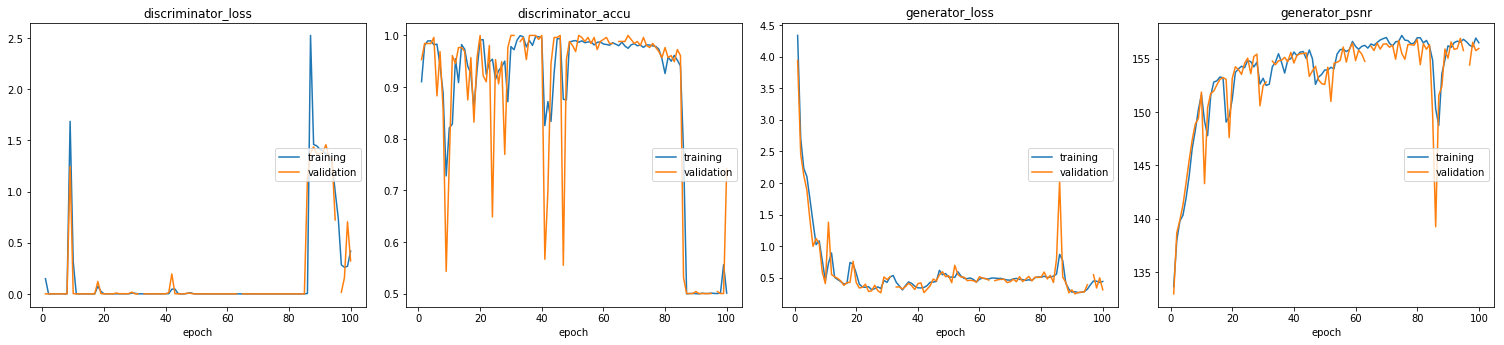

100%|██████████| 100/100 [13:26<00:00,  7.99s/epoch, discriminator_loss=0.418, discriminator_accu=0.501, generator_loss=0.442, generator_psnr=156, val_discriminator_loss=0.322, val_discriminator_accu=0.742, val_generator_loss=0.31, val_generator_psnr=156]

Tiling: lowres/bedmap2_bed.tif
Tiling: misc/REMA_100m_dem.tif
Tiling: misc/MEaSUREs_IceFlowSpeed_450m.tif
Experiment yielded Root Mean Square Error of 49.26 on test set


COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Metrics:
COMET INFO:         discriminator_accu: 0.5008680555555556
COMET INFO:         discriminator_loss: 0.4181348959294458
COMET INFO:             generator_loss: 0.4416767838928435
COMET INFO:             generator_psnr: 156.48906270209267
COMET INFO:                  rmse_test: 49.25984777384268
COMET INFO:     val_discriminator_accu: 0.7421875
COMET INFO:     val_discriminator_loss: 0.32224634289741516
COMET INFO:         val_generator_loss: 0.30959925055503845
COMET INFO:         val_generator_psnr: 155.94837079004643
COMET INFO:   Uploads:
COMET INFO:      assets: 2
COMET INFO:     figures: 0
COMET INFO:      images: 0
COMET INFO: ----------------------------
COMET INFO: Uploading stats to Comet before program termination (may take several seconds)
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: Still uploading


In [20]:
n_trials = 1
if n_trials == 1:  # run training once only, i.e. just test the objective function
    objective(enable_livelossplot=True, enable_comet_logging=True)
elif n_trials > 1:  # perform hyperparameter tuning with multiple experimental trials
    tpe_seed = int(
        os.environ["CUDA_VISIBLE_DEVICES"]
    )  # different seed for different GPU
    sampler = optuna.samplers.TPESampler(
        seed=tpe_seed
    )  # Tree-structured Parzen Estimator
    study = optuna.create_study(
        storage="sqlite:///model/logs/train.db",
        study_name="DeepBedMap_tuning",
        load_if_exists=True,
        sampler=sampler,
    )
    study.optimize(func=objective, n_trials=100, n_jobs=1)

In [21]:
if n_trials > 1:
    study = optuna.Study(
        study_name="DeepBedMap_tuning", storage="sqlite:///model/logs/train.db"
    )
    study.trials_dataframe().nsmallest(n=10, columns="value")